# Testing windninja outputs

In [9]:
df = pd.read_pickle('/home/jovyan/farsite-devAPI/data/dftable_06032023.pkl')
df.to_csv('/home/jovyan/farsite-devAPI/data/dftable_06032023.csv')

In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from dataclasses import dataclass

import contextily as ctx

import requests

@dataclass
class Station:
    name: str
    lat: float
    lon: float
    temperature: list
    wind_speed: list
    wind_direction: list
    timestamp: list
    units: dict

In [4]:
# def collect_wx_data(gdf, gdfignition, igniteidx, compareidx):
def collect_wx_data(centerlon, centerlat, radius, fromdt, todt):
    km_per_miles = 1.60934

    # ignite = gdfignition.to_crs(epsg=4326).loc[igniteidx]
    # compare = gdfignition.to_crs(epsg=4326).loc[compareidx]

    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = ignite['geometry'].centroid.x
    lat = ignite['geometry'].centroid.y
    radius = 5*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

    # fromdt = ignite['datetime'].tz_localize('US/Pacific')
    # todt = compare['datetime'].tz_localize('US/Pacific')
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    r_json = r.json()

    stations_lst = []
    for feature in r_json['features']:

        lon,lat = feature['geometry']['coordinates']

        name = feature['properties']['description']['name']
        wxid = feature['properties']['description']['id']
        provider = feature['properties']['description']['provider']
        wifire_uid = feature['properties']['description']['wifire_uid']

        timestamp = pd.to_datetime(feature['properties']['timestamp'])
        try:
            temperature = feature['properties']['temperature']
        except KeyError:
            temperature = []

        try:
            wind_speed = feature['properties']['wind_speed']
        except KeyError:
            wind_speed = []

        try:
            wind_direction = feature['properties']['wind_direction']
        except KeyError:
            wind_direction = []

        units = feature['properties']['units']

        stations_lst.append(Station(name, lat, lon, temperature, wind_speed, wind_direction, timestamp, units))
        
    return stations_lst

In [157]:
# gdf = gpd.read_file('/home/jovyan/farsite-devAPI/data/WindNinja/Outputs/CXPC1_CSVC1_DLVC1_CEEC1_CNIC1_BVRC1/')
# gdf = gdf.to_crs(epsg=3857)
# gdf

,speed,dir,AM_dir,QGIS_dir,geometry
0,7.1,352,82,172,POINT (-13345668.978 3988700.691)
1,7.0,352,82,172,POINT (-13344538.266 3988732.413)
2,7.0,352,82,172,POINT (-13343407.540 3988764.023)
3,7.0,352,82,172,POINT (-13342276.801 3988795.523)
4,7.0,352,82,172,POINT (-13341146.049 3988826.910)
...,...,...,...,...,...
19476,11.6,5,95,185,POINT (-13170903.368 4129610.002)
19477,11.6,5,95,185,POINT (-13169757.432 4129625.019)
19478,11.6,5,95,185,POINT (-13168611.489 4129639.917)
19479,11.5,5,95,185,POINT (-13167465.540 4129654.698)


In [158]:
gdf['u'] = gdf['speed']*np.cos(gdf['QGIS_dir']*np.pi/180)
gdf['v'] = gdf['speed']*np.sin(gdf['QGIS_dir']*np.pi/180)

In [164]:
gdf['u']

0        -7.030903
1        -6.931876
2        -6.931876
3        -6.931876
4        -6.931876
           ...    
19476   -11.555858
19477   -11.555858
19478   -11.555858
19479   -11.456239
19480   -11.456239
Name: u, Length: 19481, dtype: float64

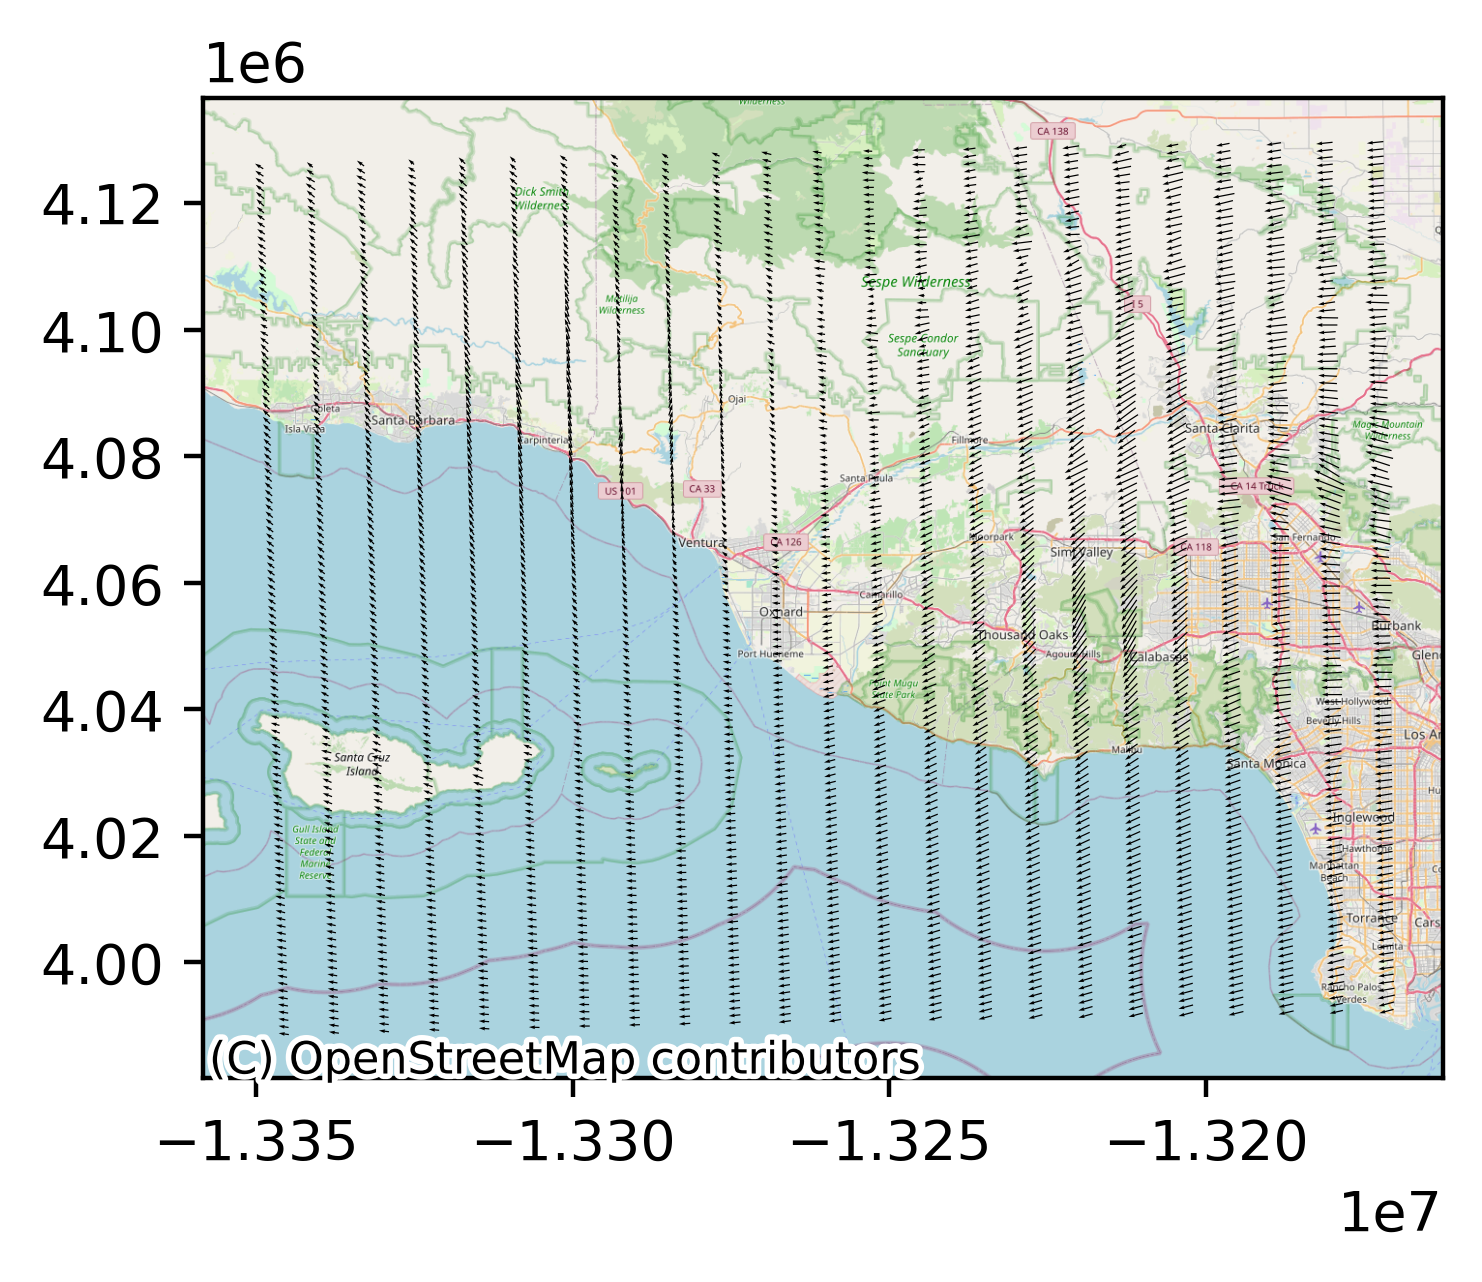

In [163]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=400)

jumpix = 7
ax.quiver(gdf['geometry'].x[::jumpix], gdf['geometry'].y[::jumpix], gdf['u'][::jumpix], gdf['v'][::jumpix],
          width=0.001, pivot='mid')

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)